<a href="https://colab.research.google.com/github/dimoynwa/Computer-vision-tasks/blob/main/Face_keypoints_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment

Check `python` and `pip` versions.

Make sure GPU is available using `nvidia-smi` command. It should return anything, this indicates that `cuda` is available

In [ ]:
!python --version
!pip --version
!nvidia-smi

Python 3.10.12
pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Tue Jan  7 18:31:52 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |   

Configure **HOME** directory.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Import pytorch and check pytorch and cuda versions.

In [ ]:
import torch

!nvcc --version
TORCH_VERSION = torch.__version__
CUDA_VERSION = torch.__version__.split('+')[-1]

print(f'Torch version: {TORCH_VERSION}')
print(f'CUDA version: {CUDA_VERSION}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Torch version: 2.5.1+cu121
CUDA version: cu121


## Install libraries

- Install `roboflow` for dataset
- Install `supervision` for labeling and annotationg images and videos
- Install `clearml` for experiment tracking

In [ ]:
!pip install roboflow supervision clearml

from IPython import display
display.clear_output()

import roboflow
print(f'Roboflow version: {roboflow.__version__}')

import supervision as sv
print(f'Supervision version: {sv.__version__}')

import clearml
print(f'ClearML version: {clearml.__version__}')

Roboflow version: 1.1.50
Supervision version: 0.25.1
ClearML version: 1.17.0


## Connect to Google drive

In [ ]:
from google.colab import drive
drive.mount(f'{HOME}/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not os.path.exists(f'{HOME}/MenposeV2'):
  DATASET_ZIP = f'{HOME}/drive/MyDrive/Data/MenposeV2.zip'
  assert os.path.exists(DATASET_ZIP)

  !unzip -q {DATASET_ZIP} -d {HOME}

DATASET_FOLDER = f'{HOME}/MenposeV2'

assert os.path.exists(DATASET_FOLDER)
assert os.path.exists(f'{DATASET_FOLDER}/train')
assert os.path.exists(f'{DATASET_FOLDER}/test')
assert os.path.exists(f'{DATASET_FOLDER}/valid')
assert os.path.exists(f'{DATASET_FOLDER}/data.yaml')

## Create supervision dataset

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{DATASET_FOLDER}/test/images',
    annotations_directory_path=f'{DATASET_FOLDER}/test/labels',
    data_yaml_path=os.path.join(DATASET_FOLDER, 'data.yaml'))

## Random image

Choose: /content/MenposeV2/test/images/14390.jpg
Image shape: (674, 747, 3)
Labels: ['0 0.4873005354752343 0.456427299703264 0.349859437751004 0.4064154302670623 0.33244310575635877 0.32242878338278935 2 0.32147255689424364 0.3724391691394659 2 0.3157175368139224 0.4280741839762611 2 0.31667737617135205 0.4794569732937685 2 0.323710843373494 0.5308382789317507 2 0.3496559571619812 0.581753709198813 2 0.39404953145917004 0.6151617210682493 2 0.43844310575635875 0.6382448071216618 2 0 0 0 0.479 0.6558605341246291 2 0 0 0 0.5360401606425703 0.6559258160237389 2 0.5707576974564926 0.6250430267062315 2 0.5958808567603748 0.5868189910979229 2 0.6178072289156626 0.5513813056379822 2 0.6342516733601071 0.5136632047477745 2 0.6458995983935744 0.4724020771513353 2 0.6542583668005355 0.4317522255192878 2 0.6575461847389559 0.3857373887240356 2 0 0 0 0 0 0 0.39622623828647924 0.270486646884273 2 0.4206064257028112 0.26042284866468846 2 0.4532275769745649 0.2569287833827893 2 0.48694511378848726 0.

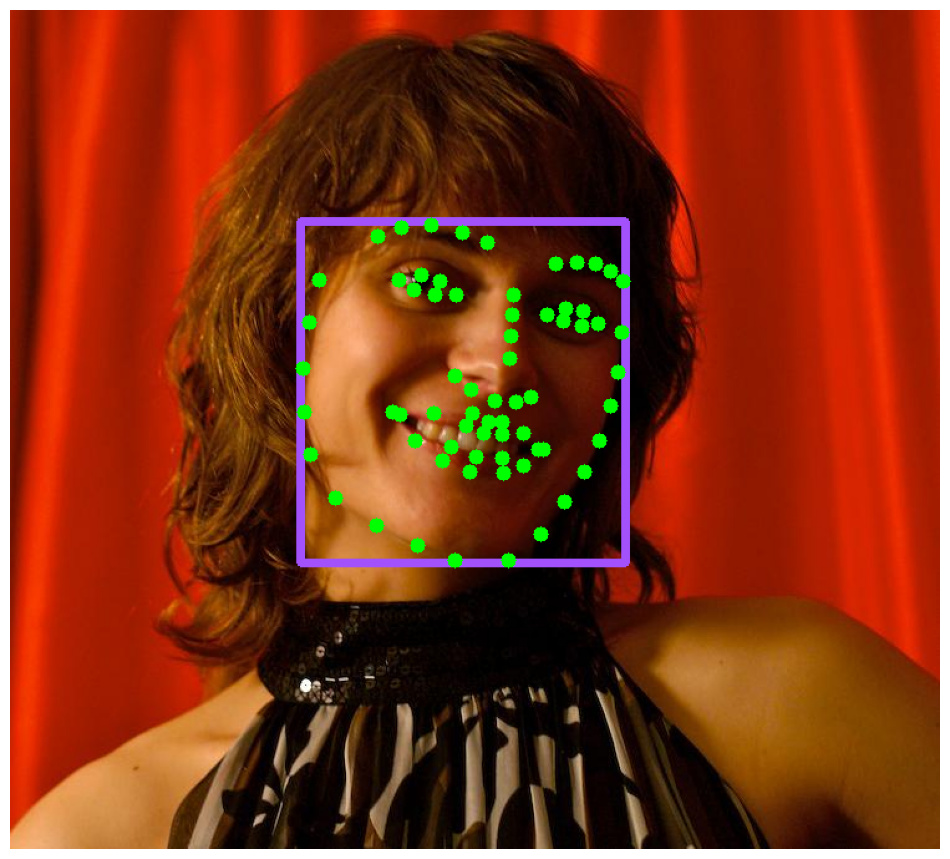

In [ ]:
from supervision.dataset.formats.yolo import _parse_box
import random
import cv2
import numpy as np

im_key = random.choice(dataset.image_paths)
print(f'Choose: {im_key}')

image_src = cv2.imread(im_key)
h, w, _ = image_src.shape

print(f'Image shape: {image_src.shape}')

labels_file = im_key.replace('images', 'labels').replace('.jpg', '.txt')
assert os.path.exists(labels_file)

with open(labels_file, 'r') as f:
  labels = f.readlines()

print(f'Labels: {labels}')

all_classes = []
all_boxes = []
all_keypoints = []

for label in labels:
  label_parts = label.split()

  class_id = int(label_parts[0])
  all_classes.append(class_id)
  x_center, y_center, width, height = map(float, label_parts[1:5])
  x_center *= w
  y_center *= h
  width *= w
  height *= h

  x1, y1, x2, y2 = _parse_box([x_center, y_center, width, height])

  all_boxes.append([x1, y1, x2, y2])

  points = list(map(float, label_parts[5:]))
  kps = []
  for i in range(0, len(points), 3):
    if points[i+2] != 2:
      continue
    kps.append([points[i] * w, points[i + 1] * h])
  all_keypoints.append(kps)

box_annotator = sv.BoxAnnotator(thickness=int(h / 100))
vertex_annotator = sv.VertexAnnotator(color=sv.Color.GREEN, radius=int(h / 100))

detections = sv.Detections(xyxy=np.array(all_boxes), class_id=np.array(all_classes))
annotated_frame = box_annotator.annotate(scene=image_src.copy(), detections=detections)

sv_keypoints = sv.KeyPoints(xy=np.array(all_keypoints), class_id=np.array(all_classes))

annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=sv_keypoints)

sv.plot_image(annotated_frame)

In [ ]:
l = iter([1, 2, 3, 4])

list(zip(l, l))

[(1, 2), (3, 4)]

## Install ultralytics

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 33.7/235.7 GB disk)


## Data prep

In [ ]:
import yaml

DATA_YAML = f'{DATASET_FOLDER}/data.yaml'
assert os.path.exists(DATA_YAML)

with open(DATA_YAML, 'r') as f:
  data_yaml = yaml.safe_load(f)

data_yaml['path'] = f'{HOME}/MenposeV2'
data_yaml['train'] = 'train/images'
data_yaml['val'] = 'valid/images'
data_yaml['test'] = 'test/images'

with open(DATA_YAML, 'w') as f:
  yaml.dump(data_yaml, f)

with open(DATA_YAML, 'r') as f:
  print(yaml.safe_load(f))

{'flip_idx': '[18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 19, 20, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 31, 32, 33, 34, 39, 38, 37, 36, 35, 49, 48, 47, 46, 51, 50, 43, 42, 41, 40, 45, 44, 58, 57, 56, 55, 54, 53, 52, 63, 62, 61, 60, 59, 68, 67, 66, 65, 64, 71, 70, 69]', 'kpt_shape': '[72, 3]', 'names': {0: 'face'}, 'path': '/content/MenposeV2', 'test': 'test/images', 'train': 'train/images', 'val': 'valid/images'}


## Create model

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11s-pose.pt')

## Log into ClearMl

In [ ]:
import clearml

clearml.browser_login()

from IPython import display
display.clear_output()

Device: cuda
Task name: yolov11yolov11s-pose-face-parts-detection-200-epochs
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=pose, mode=train, model=yolo11s-pose.pt, data=/content/MenposeV2/data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=3, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

100%|██████████| 5.35M/5.35M [00:00<00:00, 63.3MB/s]


AMP: checks passed ✅


train: Scanning /content/MenposeV2/train/labels... 6259 images, 0 backgrounds, 77 corrupt: 100%|██████████| 6259/6259 [00:11<00:00, 555.72it/s]

train: WARNING ⚠️ /content/MenposeV2/train/images/1005.jpg: ignoring corrupt image/label: negative label values [  -0.015568]
train: WARNING ⚠️ /content/MenposeV2/train/images/10860.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0251]
train: WARNING ⚠️ /content/MenposeV2/train/images/10883.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0025]
train: WARNING ⚠️ /content/MenposeV2/train/images/10886.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0639        1.12      1.1218      1.0922      1.1096      1.1201]
train: WARNING ⚠️ /content/MenposeV2/train/images/10933.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0014]
train: WARNING ⚠️ /content/MenposeV2/train/images/10970.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0051      1.0314      1.0233]
train: WARNING ⚠️ /content/MenposeV2/train/im

train: New cache created: /content/MenposeV2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning:

A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

val: Scanning /content/MenposeV2/valid/labels... 1787 images, 0 backgrounds, 17 corrupt: 100%|██████████| 1787/1787 [00:04<00:00, 414.23it/s]

val: WARNING ⚠️ /content/MenposeV2/valid/images/1109.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]
val: WARNING ⚠️ /content/MenposeV2/valid/images/13983.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0018      1.0018]
val: WARNING ⚠️ /content/MenposeV2/valid/images/14458.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0026      1.0029      1.0027      1.0019]
val: WARNING ⚠️ /content/MenposeV2/valid/images/14765.jpg: ignoring corrupt image/label: negative label values [ -0.0049973]
val: WARNING ⚠️ /content/MenposeV2/valid/images/14784.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0168      1.0438      1.0442      1.0433      1.0128      1.0036]
val: WARNING ⚠️ /content/MenposeV2/valid/images/16128.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0032       1.003      1.0032      1.003

val: New cache created: /content/MenposeV2/valid/labels.cache
Plotting labels to runs/pose/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/pose/train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.41G      1.101      11.88     0.6799      1.069      1.443         17        640: 100%|██████████| 194/194 [00:44<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.64it/s]

                   all       1770       1770      0.988      0.994      0.994      0.838          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.33G     0.7844      11.38     0.5858     0.4636      1.119         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]

                   all       1770       1770       0.99      0.993      0.995      0.857          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/200       9.2G     0.7962      10.98     0.5521     0.4917      1.121         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.54it/s]

                   all       1770       1770      0.977       0.99      0.992       0.83          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/200       9.2G       0.82      10.44      0.522     0.5232      1.134         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.983       0.99      0.993      0.839          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.22G     0.7758      9.832     0.5009     0.4871      1.109         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.977      0.987      0.993      0.858    0.00185    0.00169   4.76e-05   4.76e-06



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.24G     0.7373      9.369     0.4873     0.4606      1.083         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]

                   all       1770       1770      0.977      0.993      0.994      0.864     0.0203     0.0169    0.00196    0.00021



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/200       9.2G     0.7227      8.978     0.4765     0.4462      1.077         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.992      0.995      0.994       0.89      0.133      0.118     0.0474    0.00584



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.19G     0.7041      8.721     0.4674     0.4326      1.069          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.985      0.994      0.994      0.867       0.13      0.116     0.0307    0.00352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/200       9.2G     0.6927      8.479     0.4609     0.4221      1.061         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.993      0.991      0.995      0.892      0.195      0.172     0.0725    0.00949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.19G     0.6806      8.268     0.4562     0.4126      1.055         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.994      0.995      0.995      0.905      0.352      0.312      0.234     0.0392



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/200      9.19G     0.6743      8.076      0.448      0.406      1.048         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all       1770       1770       0.99      0.997      0.994      0.893      0.354      0.314      0.221      0.039



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/200       9.2G     0.6554      7.931     0.4415     0.3963      1.038         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]

                   all       1770       1770      0.993      0.998      0.994        0.9      0.303      0.282      0.171     0.0258



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/200      9.19G     0.6468      7.804     0.4357     0.3862      1.036         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.992      0.998      0.995      0.911       0.41      0.379      0.305     0.0578



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.19G     0.6447      7.751     0.4304     0.3856      1.035         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]

                   all       1770       1770      0.993      0.995      0.995      0.905      0.473      0.427      0.366     0.0693



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/200       9.2G     0.6448      7.637     0.4291     0.3864      1.033         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.991      0.997      0.995      0.901      0.484      0.452      0.319     0.0517



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/200       9.2G     0.6332      7.539     0.4282     0.3698      1.025         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.993      0.999      0.995       0.92      0.475      0.454      0.397     0.0695



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/200       9.2G     0.6263      7.463     0.4212     0.3714      1.025         18        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.60it/s]

                   all       1770       1770      0.995      0.996      0.995      0.913      0.554      0.524      0.474      0.101



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/200      9.21G     0.6244      7.391     0.4177     0.3678      1.024         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.989      0.997      0.994      0.911      0.498      0.464      0.438     0.0875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.19G     0.6143      7.312     0.4126     0.3582      1.018         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996      0.996      0.995       0.92      0.588      0.561       0.54      0.116



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.19G     0.6145      7.273     0.4102     0.3589      1.014         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]

                   all       1770       1770      0.993      0.997      0.995      0.917       0.63      0.601      0.583      0.133



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.19G     0.6113      7.189     0.4064     0.3597      1.021         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.992      0.998      0.994      0.912      0.583      0.566      0.509      0.109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.19G     0.6045      7.183     0.4048     0.3553      1.009         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.992      0.997      0.995       0.91      0.584      0.558      0.481      0.104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/200       9.2G     0.6001      7.178     0.4034     0.3503      1.009         17        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]

                   all       1770       1770      0.995      0.998      0.995      0.921      0.581      0.558      0.508      0.107



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.19G     0.5905      7.075     0.3967     0.3407      1.006         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.80it/s]

                   all       1770       1770      0.994      0.997      0.995      0.926      0.641       0.61      0.601      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/200       9.2G     0.5993      7.118     0.3958     0.3487      1.009         18        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.996      0.998      0.995      0.924      0.626      0.594      0.573      0.139



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.19G     0.5899      7.074     0.3947     0.3459       1.01         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]

                   all       1770       1770       0.99      0.997      0.994      0.928      0.687      0.658      0.653      0.169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/200       9.2G     0.5894      6.992     0.3912     0.3417      1.004         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.995      0.997      0.995      0.928      0.677      0.651       0.65       0.16



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/200      9.19G     0.5862      6.969     0.3893     0.3398      1.007         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.995      0.999      0.995      0.934      0.655      0.631      0.638      0.158



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/200       9.2G     0.5742      6.939     0.3871     0.3361     0.9986         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]

                   all       1770       1770      0.991      0.998      0.994      0.928      0.657      0.637      0.631      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/200       9.2G     0.5705       6.85     0.3851     0.3297     0.9977         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.997      0.998      0.995      0.926      0.642      0.605      0.604      0.142



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.19G     0.5735      6.872     0.3837     0.3302     0.9955         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.995      0.998      0.995      0.928      0.703      0.679      0.669      0.169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/200       9.2G     0.5755      6.876     0.3801      0.332     0.9986         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.58it/s]

                   all       1770       1770       0.99      0.999      0.994      0.934      0.714      0.692      0.692      0.192



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/200      9.19G     0.5704      6.831      0.375     0.3331     0.9952         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.992      0.998      0.995      0.927      0.702      0.678      0.688      0.188



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.19G     0.5667      6.767     0.3747     0.3284     0.9935         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.992      0.999      0.995      0.926      0.679      0.659       0.64      0.166



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/200       9.2G     0.5658      6.731     0.3714     0.3278     0.9962         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]

                   all       1770       1770      0.998      0.999      0.995      0.931      0.713      0.698      0.677      0.181



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.19G     0.5587      6.653      0.371     0.3227     0.9913         17        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.995      0.999      0.995      0.932      0.725      0.705      0.717      0.213



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/200      9.19G     0.5626      6.635     0.3691     0.3259     0.9907         21        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.994      0.997      0.995      0.925        0.7      0.679      0.662       0.18



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/200       9.2G     0.5549       6.54     0.3693     0.3168     0.9904         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.53it/s]

                   all       1770       1770      0.995      0.999      0.995      0.929      0.739      0.721       0.73      0.217



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.18G     0.5556      6.528     0.3681     0.3187     0.9939         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.994      0.999      0.994      0.938      0.756       0.74      0.756      0.228



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.18G     0.5585      6.537     0.3628     0.3269     0.9955         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996      0.998      0.995      0.934      0.719      0.701       0.69      0.189



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.19G     0.5522      6.467     0.3625     0.3179     0.9884         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.991      0.998      0.994       0.94      0.764      0.746      0.746      0.227



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/200       9.2G     0.5389      6.339     0.3613     0.3076     0.9796         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.995      0.999      0.995      0.938      0.758      0.738      0.761      0.247



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.19G     0.5449      6.402     0.3596     0.3099     0.9868         20        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.995      0.999      0.995      0.937      0.767      0.747      0.757      0.229



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.19G     0.5418      6.351     0.3603     0.3083     0.9856         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]

                   all       1770       1770      0.994      0.997      0.995      0.938      0.758      0.745      0.751      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/200       9.2G     0.5371      6.331     0.3544     0.3102     0.9812         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.994      0.999      0.995       0.94      0.756      0.742       0.75      0.231



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.19G      0.543       6.32     0.3516     0.3094     0.9841         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.993      0.999      0.995      0.937       0.76      0.746      0.754      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/200      9.19G     0.5312      6.273     0.3489     0.3055     0.9743         10        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.994      0.999      0.995      0.942      0.788      0.773      0.797      0.255



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/200       9.2G     0.5313      6.312     0.3471     0.3041     0.9781         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.995          1      0.995      0.935      0.777      0.763      0.779      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.19G     0.5321      6.269     0.3481     0.3028     0.9774         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.994      0.998      0.995      0.942      0.767       0.75      0.765       0.25



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/200       9.2G     0.5361       6.23     0.3446     0.3024     0.9807          7        640: 100%|██████████| 194/194 [00:38<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.995      0.999      0.995      0.942      0.755      0.737      0.756      0.246



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.19G     0.5359      6.296     0.3459     0.3054     0.9842         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996      0.998      0.995      0.943      0.774      0.762      0.784      0.254



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.19G     0.5302      6.232     0.3459     0.3021      0.977          9        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.997      0.998      0.995      0.941       0.79      0.774      0.787      0.262



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/200       9.2G     0.5251       6.17     0.3424     0.2984     0.9774         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.994      0.999      0.995       0.94      0.796      0.782      0.783      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/200       9.2G     0.5345      6.225     0.3384     0.3037     0.9828         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.997      0.999      0.995      0.937      0.767      0.753       0.77      0.251



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.19G     0.5267      6.161     0.3356     0.2967     0.9789         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.997      0.999      0.995      0.943      0.772      0.759      0.765      0.243



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/200       9.2G     0.5224      6.135     0.3356     0.2963     0.9742         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.995          1      0.995      0.944      0.792      0.778      0.795      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.19G     0.5209      6.114     0.3358     0.2933     0.9761         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996      0.999      0.995      0.947      0.801      0.785      0.809      0.272



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.19G      0.526      6.176     0.3375     0.2991     0.9756         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996      0.997      0.995      0.945      0.784      0.768      0.783      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/200       9.2G     0.5218      6.134     0.3338     0.2962     0.9751         10        640: 100%|██████████| 194/194 [00:38<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.997      0.997      0.995      0.944      0.794       0.78      0.806      0.282



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.19G      0.513      6.063     0.3345     0.2907     0.9694         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.999      0.999      0.995      0.947      0.804      0.788      0.809      0.277



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.19G     0.5185       6.07      0.328      0.292     0.9772          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996      0.999      0.995      0.942      0.775      0.759       0.78      0.264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/200       9.2G     0.5104      6.031     0.3288     0.2892     0.9689         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996      0.999      0.995      0.949      0.819      0.804      0.835      0.294



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/200       9.2G      0.511      6.021     0.3297      0.287     0.9692         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.996          1      0.995      0.947      0.803      0.785      0.818      0.287



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/200       9.2G     0.5133      6.038     0.3262     0.2949     0.9683         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


                   all       1770       1770      0.996      0.999      0.995      0.943      0.806      0.795       0.82      0.286

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/200       9.2G     0.5039      5.986     0.3212     0.2898     0.9634         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.995      0.999      0.995      0.947      0.811      0.796      0.822      0.285



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.19G     0.5147      6.035     0.3255     0.2906     0.9722         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.995          1      0.995      0.948       0.81      0.793      0.819      0.285



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/200       9.2G     0.5124      6.053     0.3252     0.2926     0.9718         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]

                   all       1770       1770      0.998      0.999      0.995      0.948      0.821      0.806      0.831      0.296



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.19G     0.5121      6.034     0.3219     0.2915     0.9712         11        640: 100%|██████████| 194/194 [00:38<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]

                   all       1770       1770      0.995      0.999      0.995      0.949      0.815      0.802       0.83      0.295



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/200       9.2G     0.5075      5.961     0.3212     0.2884     0.9674         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

                   all       1770       1770      0.996      0.999      0.994      0.949      0.819       0.81      0.834      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/200       9.2G     0.5064      5.992     0.3214     0.2868     0.9681         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996      0.999      0.994      0.948      0.825      0.811      0.835      0.297



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/200       9.2G     0.5003      5.914     0.3175     0.2831     0.9666         15        640: 100%|██████████| 194/194 [00:38<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.997      0.999      0.995      0.947      0.808      0.796      0.813      0.287



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/200       9.2G     0.5033      5.961      0.314     0.2871     0.9678         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]

                   all       1770       1770      0.996      0.999      0.995      0.949      0.834      0.823      0.849      0.314



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.19G     0.5005      5.907     0.3124     0.2852     0.9663         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]

                   all       1770       1770      0.998      0.999      0.995      0.948      0.821      0.807      0.834      0.303



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/200       9.2G     0.5012      5.938     0.3155     0.2859     0.9673         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.994      0.999      0.995       0.95       0.82      0.807      0.837      0.303



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.19G     0.4978      5.898     0.3097     0.2811     0.9655         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.995      0.951       0.83      0.819      0.846      0.315



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/200      9.18G     0.5015       5.92     0.3089     0.2861     0.9685         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.994      0.999      0.995       0.95      0.821      0.808      0.839        0.3



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.19G     0.4947      5.883     0.3121     0.2803     0.9646         12        640: 100%|██████████| 194/194 [00:39<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.992      0.999      0.995      0.947      0.829      0.818      0.835      0.299



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.19G     0.4985      5.863      0.308     0.2807     0.9642         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996      0.999      0.995      0.951      0.835      0.823      0.845      0.312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/200       9.2G     0.4925       5.81     0.3105     0.2776     0.9603          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.993      0.999      0.994      0.945      0.831      0.823      0.848      0.306



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.19G     0.4929      5.828     0.3065     0.2795     0.9622         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.62it/s]

                   all       1770       1770      0.995      0.999      0.995      0.951       0.83      0.819      0.849       0.31



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.19G     0.4882      5.805     0.3076     0.2735     0.9592         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.995      0.999      0.995       0.95      0.821       0.81      0.835        0.3



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.19G      0.484      5.765     0.3025     0.2743     0.9568         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.995      0.999      0.995       0.95      0.841      0.832      0.852      0.314



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/200       9.2G     0.4906      5.838     0.3022     0.2745     0.9594          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.54it/s]

                   all       1770       1770      0.995      0.999      0.995      0.952      0.836      0.827      0.855      0.317



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.19G     0.4845      5.804     0.3024      0.275     0.9577         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.995      0.998      0.995      0.954      0.845      0.834      0.861      0.321



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/200       9.2G     0.4888      5.819     0.2998     0.2781     0.9598         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]

                   all       1770       1770      0.996      0.998      0.995      0.951      0.842      0.831      0.854      0.318



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.19G     0.4849      5.746     0.3006     0.2742     0.9553         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all       1770       1770      0.997      0.999      0.995       0.95       0.84      0.831      0.853      0.312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/200       9.2G     0.4848       5.78     0.2986     0.2756     0.9592         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.89it/s]

                   all       1770       1770      0.995          1      0.995      0.951      0.843      0.834       0.86      0.318



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/200      9.18G      0.485      5.792     0.2965     0.2767     0.9614          7        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.994      0.999      0.995      0.951      0.833      0.824      0.845      0.314



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/200       9.2G     0.4869      5.797     0.2929     0.2745     0.9609         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

                   all       1770       1770      0.996      0.999      0.995      0.951      0.828      0.818      0.845      0.315



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.19G     0.4845      5.759     0.2955     0.2704      0.961         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.995      0.952      0.824      0.813      0.842       0.32



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/200       9.2G     0.4791      5.721     0.2942     0.2726      0.955          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.995      0.951      0.839      0.829      0.858      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.19G     0.4854      5.767     0.2927     0.2754     0.9606         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all       1770       1770      0.997      0.999      0.995      0.952      0.838      0.825      0.853      0.326



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/200       9.2G     0.4858      5.752     0.2888     0.2755     0.9583         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.997      0.999      0.995      0.952      0.838      0.828      0.853      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.19G     0.4847      5.736     0.2876     0.2736     0.9607         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.997      0.999      0.995      0.953      0.838      0.831      0.855      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/200       9.2G     0.4786      5.722     0.2895     0.2733     0.9588         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.51it/s]

                   all       1770       1770      0.996      0.999      0.995      0.953      0.831      0.824      0.848      0.318



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.18G     0.4824      5.727     0.2853     0.2745     0.9599          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.995      0.953      0.844      0.834      0.857      0.324



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/200      9.19G     0.4801      5.689     0.2886     0.2726     0.9566         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.80it/s]

                   all       1770       1770      0.996      0.999      0.995      0.951      0.841      0.832      0.852      0.321



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.19G     0.4749      5.663     0.2879     0.2671      0.956         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

                   all       1770       1770      0.995      0.999      0.995      0.952      0.844      0.834      0.857      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/200       9.2G     0.4746      5.648     0.2864     0.2679     0.9535          9        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.995      0.999      0.995      0.952      0.843      0.833      0.856      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/200      9.19G     0.4727      5.563     0.2873     0.2669     0.9536         19        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.994      0.954       0.85      0.842       0.87      0.333



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/200       9.2G     0.4687      5.583     0.2832      0.265     0.9518         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]

                   all       1770       1770      0.996      0.999      0.995      0.954      0.846      0.838      0.871      0.335



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/200      9.19G      0.469      5.566     0.2827     0.2648     0.9508         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996      0.999      0.995      0.954      0.852      0.841      0.872       0.34



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/200       9.2G     0.4669      5.606     0.2834     0.2637     0.9522         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.997      0.999      0.995      0.954      0.853      0.845      0.877      0.339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/200      9.19G       0.47      5.601     0.2816     0.2653     0.9535         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]

                   all       1770       1770      0.997      0.999      0.995      0.953      0.849       0.84      0.872      0.335



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.19G     0.4685      5.583     0.2787     0.2623     0.9507         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.996      0.999      0.995      0.953      0.842      0.832      0.864      0.337



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.19G     0.4665      5.593     0.2801     0.2622     0.9523          9        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]

                   all       1770       1770      0.997      0.999      0.995      0.954      0.851      0.841      0.874       0.34



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.19G     0.4606      5.497     0.2769     0.2585     0.9471          7        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all       1770       1770      0.996      0.999      0.995      0.954      0.849      0.841      0.876      0.342



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.19G     0.4662      5.548      0.278     0.2621     0.9489         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.997      0.999      0.995      0.954      0.855      0.846      0.878      0.347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/200       9.2G     0.4579       5.54      0.275       0.26      0.947         18        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.997      0.999      0.995      0.954      0.858      0.851      0.879       0.35



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.19G     0.4645      5.589     0.2724     0.2608     0.9512         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.863      0.858      0.884      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.19G     0.4569      5.487     0.2713       0.26     0.9453          8        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.997      0.999      0.995      0.955      0.866       0.86      0.887      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.19G     0.4593      5.472     0.2701      0.258     0.9507         15        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.863      0.855      0.881      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/200       9.2G      0.453      5.446     0.2693     0.2556     0.9435         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all       1770       1770      0.997      0.999      0.995      0.955      0.863      0.855      0.884      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.19G     0.4602      5.518     0.2727     0.2592     0.9478         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.996      0.999      0.995      0.956      0.859       0.85       0.88      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/200       9.2G     0.4539       5.46     0.2695     0.2563     0.9499         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.996      0.999      0.995      0.954      0.857       0.85      0.879      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.19G     0.4539      5.462     0.2684      0.253      0.946         16        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.857       0.85      0.879      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/200       9.2G     0.4562      5.433      0.266      0.254     0.9477         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.853      0.844      0.872      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.19G     0.4529      5.446     0.2667     0.2545     0.9481         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996      0.999      0.995      0.956      0.851      0.843       0.87      0.347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/200       9.2G     0.4532      5.435     0.2632      0.253     0.9445         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.852      0.845      0.873      0.347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.19G     0.4482      5.406     0.2652     0.2521     0.9449         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.995      0.999      0.995      0.955      0.854      0.846      0.874      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/200       9.2G     0.4438      5.379     0.2599     0.2501     0.9406         15        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955       0.86      0.853       0.88       0.35



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/200      9.19G     0.4578      5.461     0.2591     0.2573     0.9474         18        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.45it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.859      0.853      0.879      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/200       9.2G     0.4466      5.367     0.2585     0.2522      0.944         10        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.995      0.999      0.995      0.955      0.859      0.854      0.881      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/200      9.19G     0.4464      5.385     0.2588     0.2513     0.9416         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]

                   all       1770       1770      0.995          1      0.995      0.955      0.857       0.85      0.878      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.19G     0.4543      5.409     0.2575     0.2533     0.9466          9        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all       1770       1770      0.995      0.999      0.995      0.954       0.86      0.853       0.88      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/200      9.19G     0.4452       5.35     0.2578     0.2501     0.9423          8        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.995      0.999      0.995      0.954      0.861      0.855      0.883      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/200       9.2G     0.4425      5.324     0.2525     0.2505     0.9401         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]

                   all       1770       1770      0.995      0.999      0.995      0.956      0.864      0.858      0.885      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/200      9.19G     0.4463      5.323     0.2551     0.2483     0.9427         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

                   all       1770       1770      0.996      0.999      0.995      0.956      0.864      0.858      0.885      0.354



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/200       9.2G     0.4383      5.289     0.2547     0.2459     0.9417         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.862      0.856      0.883      0.354



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.19G     0.4436      5.306     0.2549     0.2483     0.9424          9        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.861      0.855      0.882      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/200       9.2G     0.4405      5.353     0.2541      0.247     0.9419         11        640: 100%|██████████| 194/194 [00:37<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.857      0.851      0.877      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.19G      0.442      5.281     0.2525     0.2479     0.9404         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996          1      0.995      0.955      0.854      0.848      0.874       0.35



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/200       9.2G     0.4416      5.342     0.2509     0.2468     0.9438         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.70it/s]

                   all       1770       1770      0.995          1      0.995      0.955      0.857       0.85      0.878      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.19G     0.4439      5.355     0.2496     0.2456     0.9414         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]

                   all       1770       1770      0.996          1      0.995      0.955      0.855      0.848      0.875      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/200       9.2G     0.4424      5.311     0.2498      0.247     0.9417         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]

                   all       1770       1770      0.995          1      0.995      0.954      0.859      0.852      0.879      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.19G     0.4388      5.269     0.2467      0.246     0.9408         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all       1770       1770      0.997      0.999      0.995      0.954      0.858      0.851      0.878      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/200       9.2G     0.4325      5.212     0.2468      0.243     0.9373         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]

                   all       1770       1770      0.996          1      0.995      0.955      0.861      0.853       0.88      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/200      9.19G     0.4292      5.237     0.2457     0.2422     0.9346         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]

                   all       1770       1770      0.996          1      0.995      0.955      0.862      0.854       0.88      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/200       9.2G     0.4359      5.215     0.2448     0.2438      0.939         18        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all       1770       1770      0.997      0.999      0.995      0.955      0.858       0.85      0.877      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/200      9.19G     0.4301      5.196     0.2446     0.2391     0.9345         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]

                   all       1770       1770      0.997      0.999      0.995      0.956      0.859      0.851      0.878      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/200       9.2G     0.4314      5.219     0.2432     0.2399     0.9398         18        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]

                   all       1770       1770      0.996      0.999      0.995      0.955      0.855      0.849      0.874      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.19G     0.4321       5.21      0.241     0.2393     0.9381         10        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.70it/s]

                   all       1770       1770      0.997      0.999      0.995      0.955      0.854      0.847      0.874      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/200       9.2G     0.4267       5.16     0.2418     0.2371     0.9393         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.997      0.999      0.995      0.955      0.855      0.848      0.875      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.19G     0.4326      5.202     0.2407     0.2407     0.9381         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all       1770       1770      0.995          1      0.995      0.956      0.857       0.85      0.878      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.19G     0.4252       5.16     0.2379     0.2375     0.9364         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.995          1      0.995      0.956      0.857       0.85      0.878      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.19G     0.4246      5.193     0.2349     0.2399     0.9348         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.853      0.846      0.873      0.356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/200       9.2G     0.4197      5.097     0.2379     0.2337     0.9309         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857       0.85      0.878      0.357



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.19G     0.4243       5.17     0.2376     0.2375     0.9348         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.851      0.879      0.358



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/200       9.2G     0.4201      5.082     0.2357     0.2358     0.9345         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.853      0.848      0.876      0.359



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.19G     0.4214       5.15     0.2343     0.2365     0.9334         10        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.853      0.848      0.876       0.36



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/200       9.2G     0.4216      5.128     0.2313     0.2357     0.9325         18        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.854      0.849      0.876      0.359



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.19G     0.4191      5.087     0.2302     0.2355       0.93         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.854      0.849      0.877      0.362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.19G      0.419      5.121     0.2306     0.2337      0.936          9        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.858      0.853       0.88      0.362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/200      9.19G     0.4164      5.067     0.2297     0.2349     0.9334          9        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.858      0.853       0.88      0.363



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/200       9.2G     0.4146      5.021     0.2278     0.2324     0.9309         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.857      0.852       0.88      0.363



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.19G     0.4213      5.125     0.2271      0.234      0.935         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.857      0.851      0.879      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/200       9.2G     0.4109      5.063     0.2287     0.2293     0.9307         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.70it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.854      0.849      0.876      0.363



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.19G     0.4095      4.957     0.2259     0.2281      0.931         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

                   all       1770       1770      0.997          1      0.995      0.956      0.857      0.851      0.879      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/200       9.2G     0.4142      5.061      0.225     0.2315     0.9301         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.856       0.85      0.877      0.365



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.19G     0.4067      4.964     0.2257     0.2286     0.9279          9        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.856      0.851      0.877      0.365



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/200       9.2G     0.4129      5.031     0.2227     0.2298     0.9311         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.856      0.851      0.878      0.365



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/200      9.19G     0.4045      4.924     0.2218     0.2244     0.9251         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.855       0.85      0.877      0.367



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/200       9.2G     0.4095      4.939     0.2216     0.2242     0.9287         14        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.856      0.851      0.879      0.367



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/200      9.19G     0.4085      5.002     0.2191     0.2261     0.9298         15        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.997          1      0.995      0.958      0.853      0.849      0.876      0.367



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/200       9.2G     0.4011      4.915      0.219     0.2235     0.9242         19        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]

                   all       1770       1770      0.997          1      0.995      0.957      0.855      0.851      0.878      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.19G     0.4034      4.942     0.2198     0.2247     0.9292         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.855      0.851      0.878      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    167/200       9.2G     0.4031      4.963     0.2181      0.226     0.9289         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.852      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.18G     0.4013      4.912     0.2173     0.2243     0.9282          8        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.858      0.855       0.88      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/200       9.2G     0.4016       4.89     0.2168     0.2247      0.927         12        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.858      0.854      0.879      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.19G     0.4006      4.916     0.2179      0.222     0.9246         13        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.854      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/200       9.2G     0.3982      4.902     0.2133     0.2229     0.9236         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.80it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.855      0.852      0.876      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/200      9.19G     0.4002      4.916     0.2143     0.2219       0.93         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.73it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.851      0.876      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/200       9.2G     0.3978      4.893     0.2135     0.2213     0.9268         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.857      0.854      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/200      9.19G     0.3912       4.84     0.2107     0.2175     0.9191         12        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.853      0.876      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/200       9.2G     0.3962      4.851     0.2121      0.219     0.9252         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.853      0.875      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/200      9.19G     0.3898      4.796     0.2081     0.2183     0.9199         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.65it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.855      0.852      0.875      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/200       9.2G     0.3849      4.819     0.2081     0.2139     0.9213         12        640: 100%|██████████| 194/194 [00:36<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.859      0.856      0.878       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/200      9.19G     0.3894      4.816     0.2088     0.2157     0.9232         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.858      0.854      0.877      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/200       9.2G     0.3882      4.791     0.2065     0.2154     0.9239         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.858      0.854      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/200      9.19G     0.3866      4.763     0.2056     0.2149     0.9198         10        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.859      0.855      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/200       9.2G     0.3855      4.763     0.2054      0.212     0.9222         16        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.858      0.855      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.19G     0.3827      4.734     0.2056     0.2115     0.9196         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.858      0.855      0.878      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/200       9.2G     0.3872      4.778     0.2024     0.2165     0.9224         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

                   all       1770       1770      0.996          1      0.995      0.957       0.86      0.856      0.879       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.19G     0.3802      4.707     0.2034     0.2121     0.9176         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]

                   all       1770       1770      0.996          1      0.995      0.957      0.859      0.855      0.879       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/200       9.2G     0.3799      4.712     0.2036     0.2127      0.921         11        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]

                   all       1770       1770      0.996          1      0.995      0.956       0.86      0.856       0.88       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.19G     0.3747       4.69     0.1984     0.2094     0.9166         15        640: 100%|██████████| 194/194 [00:38<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]

                   all       1770       1770      0.996          1      0.995      0.956       0.86      0.856      0.879       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/200       9.2G       0.38      4.722     0.1996     0.2122     0.9194         17        640: 100%|██████████| 194/194 [00:38<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.40it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.859      0.855      0.878       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.19G     0.3748      4.649     0.1982     0.2073     0.9172         13        640: 100%|██████████| 194/194 [00:38<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.858      0.855      0.877       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.19G     0.3706       4.64     0.1971     0.2061     0.9138          7        640: 100%|██████████| 194/194 [00:38<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.854      0.877       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.19G     0.3711      4.618     0.1953     0.2056     0.9142         14        640: 100%|██████████| 194/194 [00:38<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.68it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.854      0.877       0.37


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.43G     0.2852      2.511    0.09659     0.1496     0.8423          6        640: 100%|██████████| 194/194 [00:39<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.853      0.876       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/200      9.18G     0.2801      2.476    0.09194     0.1447      0.845          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.854      0.876       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/200      9.19G     0.2774      2.449    0.08882     0.1434     0.8373          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.857      0.853      0.876       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/200      9.19G     0.2748      2.437    0.08612     0.1407     0.8379          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.856      0.852      0.876      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/200      9.19G     0.2752      2.425    0.08512     0.1409     0.8398          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.856      0.853      0.876       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/200      9.18G     0.2711      2.399     0.0831     0.1388     0.8355          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.854      0.851      0.874       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/200      9.19G     0.2686      2.385    0.08085     0.1382     0.8332          6        640: 100%|██████████| 194/194 [00:38<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.854      0.851      0.875       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/200      9.18G     0.2704      2.369    0.07993     0.1382     0.8356          6        640: 100%|██████████| 194/194 [00:38<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]

                   all       1770       1770      0.996          1      0.995      0.955      0.855      0.851      0.875       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.19G     0.2679      2.357     0.0794     0.1376     0.8327          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.856      0.853      0.876      0.371



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/200      9.18G     0.2651      2.351    0.07788     0.1355     0.8356          6        640: 100%|██████████| 194/194 [00:37<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]

                   all       1770       1770      0.996          1      0.995      0.956      0.855      0.851      0.874       0.37



200 epochs completed in 2.737 hours.
Optimizer stripped from runs/pose/train3/weights/last.pt, 25.5MB
Optimizer stripped from runs/pose/train3/weights/best.pt, 25.5MB

Validating runs/pose/train3/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s-pose summary (fused): 257 layers, 12,556,635 parameters, 0 gradients, 34.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:11<00:00,  2.52it/s]


                   all       1770       1770      0.996          1      0.995      0.957      0.856      0.853      0.878      0.369
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/pose/train3


██████████████████████████████▉ 100% | 24.32/24.32 MB [00:00<00:00, 53.66MB/s]: 


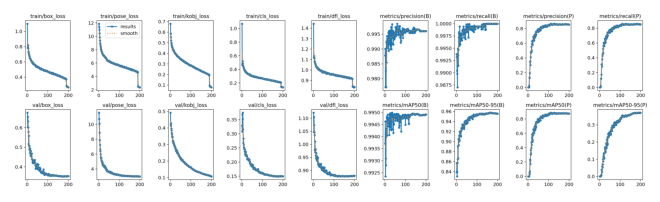

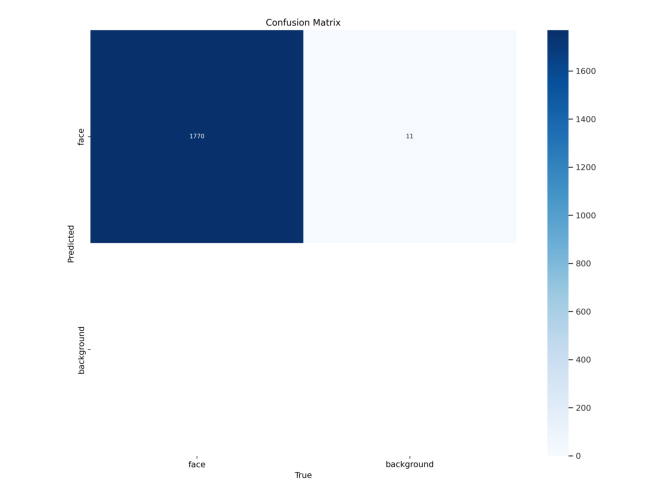

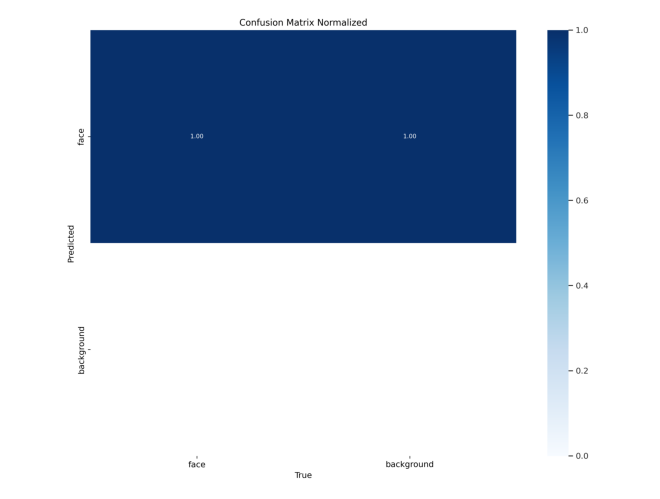

In [ ]:
from clearml import Task

project_name = 'Face parts detection'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

MODEL_VARIANT = 's'

epochs = 200
variant = f'yolov11{MODEL_VARIANT}'
batch_size = 32
imgsz=640

task_name = f'yolov11{variant}-pose-{project_name.lower().replace(" ", "-")}-{epochs}-epochs'
print(f'Task name: {task_name}')

task = Task.init(project_name=project_name, task_name=task_name, reuse_last_task_id=False)

# The model variant
variant = f'yolov11{MODEL_VARIANT}-pose'
task.set_parameter('model_variant', variant)

# Load model
args = dict(data=f'{DATASET_FOLDER}/data.yaml',
            epochs=epochs,
            patience=0,
            batch=batch_size,
            device=device)

task.connect(args)

results = model.train(data=DATA_YAML, epochs=epochs, imgsz=imgsz, batch=batch_size, save_period=3)

# !yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs={epochs} imgsz=640

task.close()

## Test the model on image

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount(f'{HOME}/drive')

Mounted at /content/drive


In [ ]:
ZIDANE_IMAGE = f'{HOME}/drive/MyDrive/Data/zidane.jpg'
assert os.path.exists(ZIDANE_IMAGE)

In [ ]:
!pip install ultralytics supervision clearml

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 32.7/235.7 GB disk)


In [ ]:
import clearml

clearml.browser_login()

from IPython import display
display.clear_output()

In [ ]:
from clearml import Task, Model
from ultralytics import YOLO

task_id = '1bd7134986b94175a35c217d5ae9250c'

model = Model(model_id='027640107ef448dabf0340ecec608de3')
model_path = model.get_local_copy()
model_path

2025-01-14 20:32:37,263 - clearml.storage - INFO - Downloading: 24.32MB from https://files.clear.ml/Face%20parts%20detection/yolov11yolov11s-pose-face-parts-detection-200-epochs.1bd7134986b94175a35c217d5ae9250c/models/best.pt


███████████████████████████████ 100% | 24.32/24.32 MB [00:01<00:00, 18.80MB/s]: 

2025-01-14 20:32:38,562 - clearml.storage - INFO - Downloaded 24.32 MB successfully from https://files.clear.ml/Face%20parts%20detection/yolov11yolov11s-pose-face-parts-detection-200-epochs.1bd7134986b94175a35c217d5ae9250c/models/best.pt , saved to /root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best.pt


'/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best.pt'

In [ ]:
if not os.path.exists(f'{HOME}/MenposeV2'):
  DATASET_ZIP = f'{HOME}/drive/MyDrive/Data/MenposeV2.zip'
  assert os.path.exists(DATASET_ZIP)

  !unzip -q {DATASET_ZIP} -d {HOME}

DATASET_FOLDER = f'{HOME}/MenposeV2'

In [ ]:
assert os.path.exists(model_path)

my_yolo_model = YOLO(model_path)
yolo_pose_model = YOLO('yolov8s-pose.pt')

100%|██████████| 22.4M/22.4M [00:00<00:00, 24.2MB/s]



0: 608x640 1 face, 72.6ms
Speed: 16.4ms preprocess, 72.6ms inference, 778.0ms postprocess per image at shape (1, 3, 608, 640)
Detections: Detections(xyxy=array([[        157,          26,         350,         219]], dtype=float32), mask=None, confidence=array([    0.93263], dtype=float32), class_id=array([0]), tracker_id=None, data={'class_name': array(['face'], dtype='<U4')}, metadata={})
Keypoints: KeyPoints(xy=array([[[     183.14,      30.746],
        [     173.66,       54.56],
        [     165.98,      80.408],
        [     161.62,      107.56],
        [     163.28,      134.61],
        [     171.33,      159.72],
        [      183.5,      182.39],
        [     198.34,      201.04],
        [          0,           0],
        [     218.12,      211.86],
        [          0,           0],
        [      239.2,      214.32],
        [     258.82,      204.49],
        [     277.02,      191.86],
        [        295,       178.1],
        [     310.46,      162.27],
      

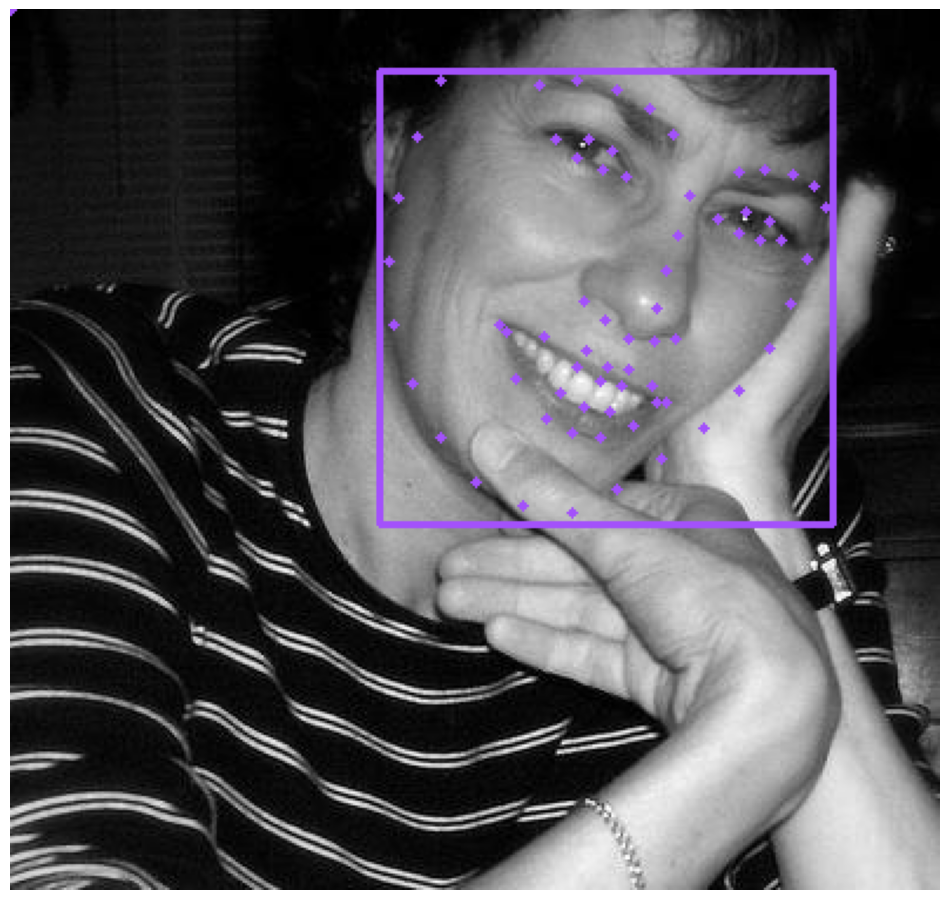

In [ ]:
import supervision as sv
import cv2
import numpy as np
import random

test_folder = f'{DATASET_FOLDER}/test/images'
assert os.path.exists(test_folder)

random_image = random.choice(os.listdir(test_folder))
image_path = os.path.join(test_folder, random_image)
assert os.path.exists(image_path)

image_src = cv2.imread(image_path)

results = my_yolo_model.predict(source=image_src, save=False)

sv_res = sv.Detections.from_ultralytics(results[0])
sv_kps = sv.KeyPoints.from_ultralytics(results[0])

print(f'Detections: {sv_res}')
print(f'Keypoints: {sv_kps}')

box_annotator = sv.BoxAnnotator(thickness=2)
vertex_annotator = sv.VertexAnnotator(radius=2)

annotated_frame = box_annotator.annotate(scene=image_src, detections=sv_res)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=sv_kps)

sv.plot_image(annotated_frame)

### Export model to TF lite

In [ ]:
# Export the model to TFLite format
my_yolo_model.export(format="tflite")  # creates 'yolo11n_float32.tflite'

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 221, 8400) (24.3 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.26.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 251.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 313.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.6/445.6 kB 328.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

100%|██████████| 1.11M/1.11M [00:00<00:00, 152MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 46.09file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ✅ 2.3s, saved as '/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best.onnx' (48.4 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.26.3...
TensorFlow SavedModel: export success ✅ 310.9s, saved as '/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best_saved_model' (124.0 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as '/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best_saved_model/930581dca8f4c02e046725276872745a.best_float32.tflite' (49.1 MB)

Export complete (312.8s)
Results saved to /root/.clearml/cache/storage_manager/global
Predict:         yolo predict task=pose model=/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best_saved_model/930581dca8f4c02e046725276872745a.best_float32.tflite imgsz=640  
Validate:        yolo val task=

'/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best_saved_model/930581dca8f4c02e046725276872745a.best_float32.tflite'

In [ ]:
path_model = '/root/.clearml/cache/storage_manager/global/930581dca8f4c02e046725276872745a.best_saved_model/930581dca8f4c02e046725276872745a.best_float32.tflite'
assert os.path.exists(path_model)


In [ ]:
from google.colab import files
files.download(path_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>